In [1]:
import matplotlib.pyplot as plt
import json

In [4]:
with open('vocab/vocab.json', 'r', encoding="utf-8") as vocab_file, open('vocab/sino_viet_words.json', 'r', encoding="utf-8") as words_file:
    base_vocab = json.load(vocab_file)
    sino_viet_words = json.load(words_file)


with open("vocab/large_vocab.json", 'r', encoding="utf-8") as large_vocab_file:
    large_vocab = json.load(large_vocab_file)

# with open("large_sino_viet_words.json", 'r', encoding="utf-8") as large_sino_viet_words_file:
# print(base_vocab)

In [5]:
num_readings = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}
for sino in base_vocab:
    readings = len(base_vocab[sino])
    num_readings[readings] += 1
print(len(base_vocab))

7688


In [45]:
with open("large_sino_viet_words.json", 'w', encoding="utf-8") as large_sino_viet_words_file:
    keys = list(large_vocab.keys())
    json.dump(keys, large_sino_viet_words_file, ensure_ascii=False, indent=4)

In [6]:
s = {}
s['s'] = [1, 2]
print(s['s'][1])

2


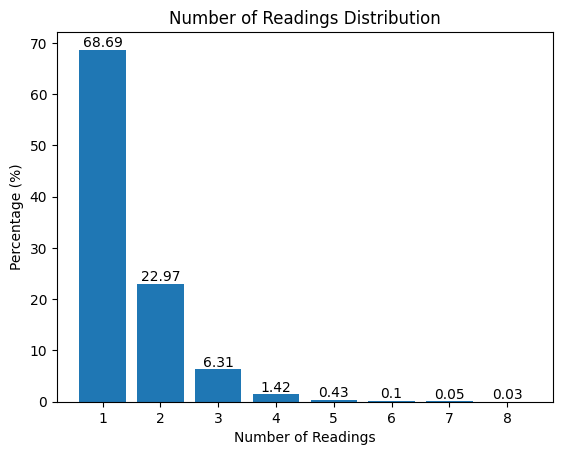

In [42]:

# Calculate the total number of readings
total_readings = sum(num_readings.values())

# Calculate the percentage of each number of readings
readings_percentage = [round(value / total_readings * 100, 2) for value in num_readings.values()]

# Extract the keys and values from the num_readings dictionary
keys = list(num_readings.keys())
values = readings_percentage

# Plot the bar graph
plt.bar(keys, values)
for i, v in enumerate(values):
    plt.text(keys[i], v, str(v), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Number of Readings')
plt.ylabel('Percentage (%)')
plt.title('Number of Readings Distribution')
plt.savefig("others/reading_distribution.png")
# Display the plot
plt.show()

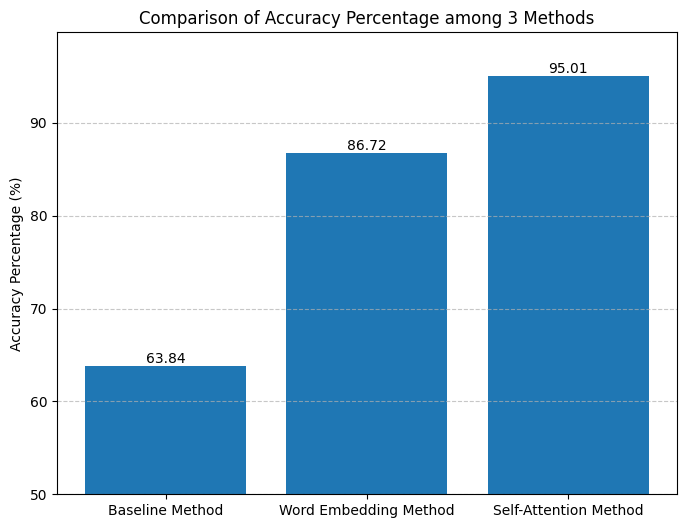

In [7]:
import matplotlib.pyplot as plt

# Data
data = [63.84, 86.72, 95.01]
categories = ['Baseline Method', 'Word Embedding Method', 'Self-Attention Method']

# Create plot
plt.figure(figsize=(8, 6))
plt.bar(categories, data)

# plt.xlabel('Method')
plt.ylabel('Accuracy Percentage (%)')
plt.title('Comparison of Accuracy Percentage among 3 Methods')

plt.ylim(50, None)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(data):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.savefig('others/comparison.pdf')
plt.show()



In [34]:
large_vocab = {}
with open("vocab/dict.txt", 'r', encoding="utf-8") as dict_file:
    for line in dict_file.readlines():
        key, value = line.strip().split(':')
        if ',' in value:
            large_vocab[key] = value.split(',')
        elif ';' in value:
            large_vocab[key] = value.split(';')
        else:
            large_vocab[key] = [value]

with open("vocab/large_vocab.json", 'w', encoding="utf-8") as large_vocab_file:
    json.dump(large_vocab, large_vocab_file, ensure_ascii=False, indent=4)

In [2]:
y = range(1, 21)
y[-1]

20

170414
2941
2


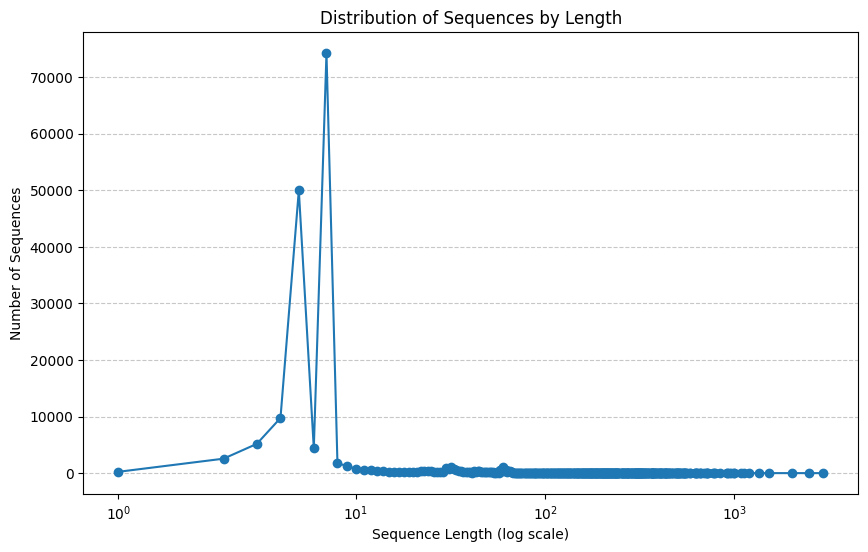

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_sentence_length_frequencies(data):
    # Calculate the lengths of sentences
    sentence_lengths = [len(sentence.split()) for _, sentence in data]

    # Count the frequency of each sentence length
    length_frequencies = Counter(sentence_lengths)

    # Sort lengths
    lengths = sorted(length_frequencies.keys())
    print(lengths[-1])
    print(lengths[1])
    frequencies = [length_frequencies[length] for length in lengths]

    # Plot the frequencies
    plt.figure(figsize=(10, 6))
    plt.plot(lengths, frequencies, marker='o', linestyle='-')
    plt.xscale('symlog')
    plt.xlabel('Sequence Length (log scale)')
    plt.ylabel('Number of Sequences')
    plt.title('Distribution of Sequences by Length')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('others/length_freq.svg')
    plt.show()

def load_data(data_file):
    data = []
    with open(data_file, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            if ',' not in line:
                continue
            sino_sent, viet_sent = line.strip().split(',')
            data.append((sino_sent, viet_sent))
    return data

train_data_path = "data/train.txt"
test_data_path = "data/test.txt"
train_data = load_data(train_data_path)
test_data = load_data(test_data_path)
sivi_data = train_data + test_data
print(len(sivi_data))
# Assuming `sivi_data` is your dataset
plot_sentence_length_frequencies(sivi_data)


Number of sentences: 170414
Average sentence length: 11.12
Max sentence length: 2941
Number of Sino-Vietnamese characters: 1895506
Single-reading characters percentage: 71.12%
Multiple-reading characters percentage: 28.88%
Number of distinct Sino-Vietnamese characters: 7688
Number of distinct Vietnamese readings: 1968
[0, 1348136, 436114, 101182, 3942, 3528, 2604]


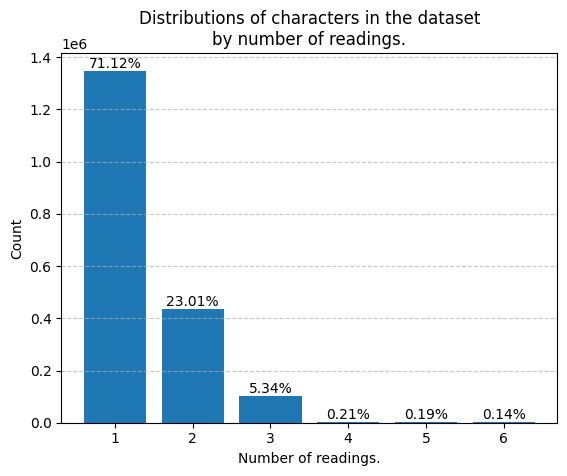

In [3]:
import matplotlib.pyplot as plt
import json
def load_data(data_file):
    data = []
    with open(data_file, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            if ',' not in line:
                continue
            sino_sent, viet_sent = line.strip().split(',')
            data.append((sino_sent, viet_sent))
    return data

train_data_path = "data/train.txt"
test_data_path = "data/test.txt"
train_data = load_data(train_data_path)
test_data = load_data(test_data_path)
sivi_data = train_data + test_data

with open('vocab/vocab.json', 'r', encoding='utf-8') as vocab_file:
    base_vocab = json.load(vocab_file)

count = [0, 0, 0, 0, 0, 0, 0]
total_len = 0
distinct_sino = set()
distinct_viet = set()
max_len = 0
for sino_seq, viet_seq in sivi_data:
    total_len += len(sino_seq)
    if len(sino_seq) > max_len: 
        max_len = len(sino_seq)
    for sino, viet in zip(sino_seq, viet_seq.split()):
        num_spellings = len(base_vocab[sino])
        count[num_spellings] += 1
        distinct_sino.add(sino)
        distinct_viet.add(viet)

x = ['1', '2', '3', '4', '5', '6']
total_char = sum(count)
multiple_char = total_char - count[1]
mul_per = multiple_char / total_char * 100
single_per = count[1] / total_char * 100

print(f"Number of sentences: {len(sivi_data)}")
print(f"Average sentence length: {(total_len / len(sivi_data)):.2f}")
print(f"Max sentence length: {max_len}")
print(f"Number of Sino-Vietnamese characters: {total_char}")
print(f"Single-reading characters percentage: {single_per:.2f}%")
print(f"Multiple-reading characters percentage: {mul_per:.2f}%")
print(f"Number of distinct Sino-Vietnamese characters: {len(distinct_sino)}")
print(f"Number of distinct Vietnamese readings: {len(distinct_viet)}")
print(count)





plt.bar(x, count[1:])
plt.xlabel('Number of readings.')
plt.ylabel('Count')
plt.title(f'Distributions of characters in the dataset\nby number of readings.')
# Add percentage on top of the bar
total_count = sum(count[1:])
for i, v in enumerate(count[1:]):
    percentage = round(v / total_count * 100, 2)
    plt.text(i, v, f'{percentage}%', ha='center', va='bottom')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('others/single_multiple_freq.pdf')
plt.show()
# x = ['Single', 'Multiple']
# plt.bar(x, count[1:], color=['blue', 'green'])
# plt.xlabel('Number of Base Vocab')
# plt.ylabel('Count')
# plt.title('Count of Base Vocab')
# plt.savefig('others/single_multiple_freq.pdf')
# plt.show()

In [17]:
import matplotlib.pyplot as plt
import json
def load_data(data_file):
    data = []
    with open(data_file, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            if ',' not in line:
                continue
            sino_sent, viet_sent = line.strip().split(',')
            data.append((sino_sent, viet_sent))
    return data

train_data_path = "data/train.txt"
test_data_path = "data/test.txt"
train_data = load_data(train_data_path)
test_data = load_data(test_data_path)
sivi_data = train_data + test_data

def load_predictions(pred_file):
    predictions = []
    with open(pred_file, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            sino_sent, viet_sent, _ = line.strip().split(',')
            predictions.append((sino_sent, viet_sent))
    return predictions

pred_path = "Config_5/test_results/source_label_pred.txt"
test_pred = load_predictions(pred_path)

with open('vocab/vocab.json', 'r', encoding='utf-8') as vocab_file:
    base_vocab = json.load(vocab_file)

def cal_appearance_freq(char):
    total_char = 1895506
    count = 0
    for sino_seq, viet_seq in sivi_data:
        for c in sino_seq:
            if c == char:
                count += 1
    return count / total_char * 100


pred_statistic = {}
pred_correct_freq = {}

for sino_seq, viet_seq in test_pred:
    for sino, viet in zip(sino_seq, viet_seq.split()):
        if sino not in pred_correct_freq:
            pred_correct_freq[sino] = [0, 0]
        # incorrect
        if '#' in viet:
            if sino in pred_statistic:
                pred_statistic[sino] = [pred_statistic[sino][0] + 1, pred_statistic[sino][1]]
            else:
                pred_statistic[sino] = [1, 0]
        # correct
        else:
            if sino in pred_statistic:
                pred_statistic[sino] = [pred_statistic[sino][0] + 1, pred_statistic[sino][1] + 1]
            else:
                pred_statistic[sino] = [1, 1]
        pred_correct_freq[sino][0] = pred_statistic[sino][1] / pred_statistic[sino][0] * 100

for char in pred_statistic.keys():
    pred_correct_freq[char][1] = cal_appearance_freq(char) 




In [24]:
# Sort the characters based on pred_correct_freq in descending order
sorted_chars = sorted(pred_correct_freq.items(), key=lambda x: (x[1][0], x[1][1]), reverse=True)

# Get the top 10 characters with highest pred_correct_freq
top_10_high_freq_chars = sorted_chars[:10]

# Get the top 10 characters with lowest pred_correct_freq
top_10_low_freq_chars = sorted_chars[-10:]

print(pred_correct_freq['一'])

[100.0, 0.8641492034316958]


In [18]:


# Write the top 10 characters with highest pred_correct_freq to a file
with open('others/top_10_high_freq_chars.txt', 'w', encoding='utf-8') as high_freq_file:
    for char, correct_pred_freq, appearance_freq in top_10_high_freq_chars:
        pred_stat = pred_statistic[char]
        high_freq_file.write(f"Character: {char}\n")
        high_freq_file.write(f"Num readings: {len(base_vocab[char])}\n")
        high_freq_file.write(f"Appearances in test set: {pred_stat[0]}\n")
        high_freq_file.write(f"Correct preds in test set: {pred_stat[1]}\n")
        high_freq_file.write(f"Correct preds per: {correct_pred_freq}\n")
        high_freq_file.write(f"appearance_freq: {appearance_freq}\n\n")

# Write the top 10 characters with lowest pred_correct_freq to a file
with open('others/top_10_low_freq_chars.txt', 'w', encoding='utf-8') as low_freq_file:
    for char, correct_pred_freq, appearance_freq in top_10_low_freq_chars:
        pred_stat = pred_statistic[char]
        low_freq_file.write(f"Character: {char}\n")
        low_freq_file.write(f"Num readings: {len(base_vocab[char])}\n")
        low_freq_file.write(f"Appearances in test set: {pred_stat[0]}\n")
        low_freq_file.write(f"Correct preds in test set: {pred_stat[1]}\n")
        low_freq_file.write(f"Correct preds per: {correct_pred_freq}\n")
        low_freq_file.write(f"appearance_freq: {appearance_freq}\n\n")

ValueError: not enough values to unpack (expected 3, got 2)

176
178


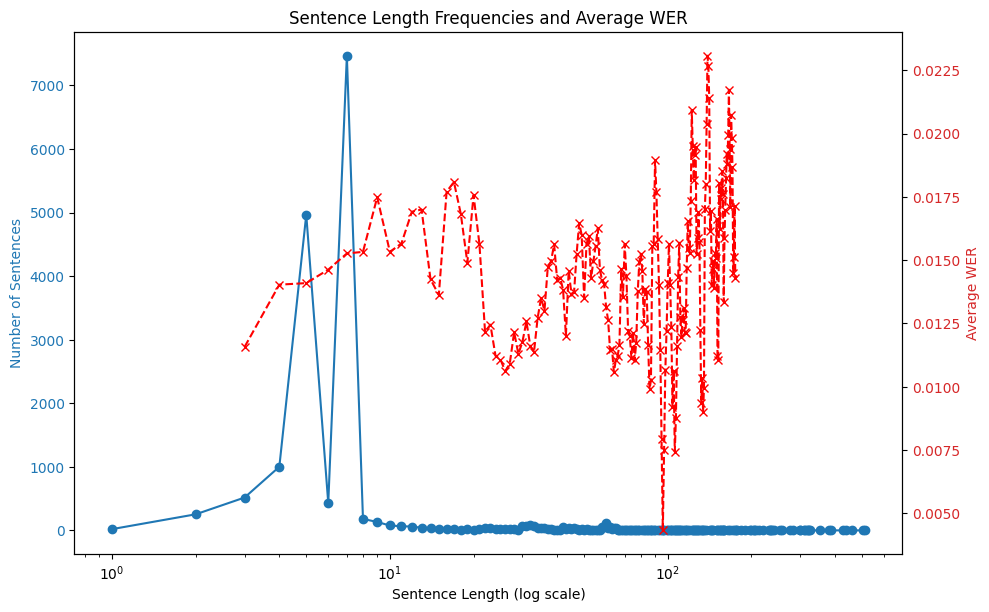

In [8]:
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
from jiwer import wer

def moving_averages(data, window_size=10):
    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = sum(window) / window_size
        moving_averages.append(window_average)
    return moving_averages

def plot_sentence_length_frequencies_and_wer(data, predictions, max_length=512):
    # Filter data and predictions to only include sequences with length shorter than max_length
    # filtered_data = [(sino_sent, viet_sent) for sino_sent, viet_sent in data if len(viet_sent.split()) < max_length]
    # filtered_predictions = [pred for i, pred in enumerate(predictions) if len(data[i][1].split()) < max_length]

    # Calculate the lengths of sentences
    sentence_lengths = [len(sentence.split()) for sentence in data]

    # Count the frequency of each sentence length
    length_frequencies = Counter(sentence_lengths)

    # Calculate WERs for each sentence
    wers_by_length = defaultdict(list)
    for viet_sent, predicted_sent in zip(data, predictions):
        wer_score = wer(viet_sent, predicted_sent)
        length = len(viet_sent.split())
        wers_by_length[length].append(wer_score)

    # Calculate average WER for each sentence length
    avg_wers = {length: np.mean(wers) for length, wers in wers_by_length.items()}
    # Prepare data for plotting
    lengths = sorted(length_frequencies.keys())
    frequencies = [length_frequencies[length] for length in lengths]
    avg_wers_values = [avg_wers[length] if length in avg_wers else None for length in lengths]

    window_size = 6
    avg_wers_values = moving_averages(avg_wers_values, window_size)
    wers_length = list(range(window_size // 2, len(avg_wers_values) + window_size // 2))
    print(len(avg_wers_values) + window_size // 2)
    print(len(lengths))

    # Plot the frequencies and average WERs
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('Sentence Length (log scale)')
    ax1.set_ylabel('Number of Sentences', color='tab:blue')
    ax1.plot(lengths, frequencies, marker='o', linestyle='-', color='tab:blue', label='Number of Sentences')
    ax1.set_xscale('log')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Average WER', color='tab:red')
    ax2.plot(wers_length, avg_wers_values, marker='x', linestyle='--', color='red', label='Average WER')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title('Sentence Length Frequencies and Average WER')
    plt.show()

def load_data(data_file):
    data = []
    predictions = []
    with open(data_file, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            if ',' not in line:
                continue
            label, pred = line.strip().split(',', 1)
            data.append(label)
            predictions.append(pred)
    return data, predictions
# Assuming `sivi_data` is your dataset and `predictions` are your model's predictions
data_file = "Config_5/test_results/label_pred.txt"
sivi_data, predictions = load_data(data_file)  # Replace with your actual model predictions
plot_sentence_length_frequencies_and_wer(sivi_data, predictions)
